# Week 7 Notebook for generating some visualizations on poster and likely report

In [1]:
from _Setup import *

Installing dependencies from requirements.txt...
All dependencies installed successfully.


Define paths to model

In [2]:
ets_file_path = project_root / "Model_Outputs" / "ets_model_results.csv"
arima_file_path = project_root / "Model_Outputs" / "arima_model_results.csv"


Open results into dataframes

In [3]:

with open(lstm_mape_results_file3, 'rb') as file:
    lstm_model_results = pickle.load(file)


with open(nn_mape_results_file2, 'rb') as file:
    nn_model_results = pickle.load(file)

In [4]:
ets_model_results = pd.read_csv(ets_file_path)
arima_model_results = pd.read_csv(arima_file_path)

We want visualization of MAPE at each time step for each model and a forecast as well. We will be creating a dataset that can be used by GraphPad Prism for better visualization quality.

Trevor did ETS and ARIMA, model results are stored as the predictions, so we will need to calculate the MAPE for those two. NN and LSTM already have these values.

In [5]:
# Extract the 'predictions' column from nn_model_results
nn_predictions = nn_model_results['predictions']

# Create a new DataFrame with the same index and columns as ets_model_results
nn_predictions_df = pd.DataFrame(nn_predictions.tolist(), index=nn_model_results['sector'], columns=ets_model_results.columns)

# Reset the index to match the format of ets_model_results
nn_predictions_df.reset_index(inplace=True)
nn_predictions_df.rename(columns={'index': 'Area of Responsibility'}, inplace=True)


Looks like the ets and ARIMA had index removed, let's put it back

In [6]:
# Extract 'Area of Responsibility' from nn_predictions_df
area_of_responsibility = nn_predictions_df['sector']

# Add 'Area of Responsibility' to ets_model_results and arima_model_results
ets_model_results.insert(0, 'Area of Responsibility', area_of_responsibility)
arima_model_results.insert(0, 'Area of Responsibility', area_of_responsibility)

In [7]:
# Extract the 'predictions' column from nn_model_results
lstm_predictions = lstm_model_results['predictions']

# Create a new DataFrame with the same index and columns as ets_model_results
lstm_predictions_df = pd.DataFrame(lstm_predictions.tolist(), index=lstm_model_results['sector'], columns=ets_model_results.columns[1:])

# Reset the index to match the format of ets_model_results
lstm_predictions_df.reset_index(inplace=True)
lstm_predictions_df.rename(columns={'index': 'Area of Responsibility'}, inplace=True)

In [8]:
test_data = pd.read_csv(sector_data_csv_path_test_pivoted, index_col='Area of Responsibility')
train_data = pd.read_csv(sector_data_csv_path_train_pivoted, index_col='Area of Responsibility')

In [9]:
def plot_data(sector):
    ets_results = ets_model_results[ets_model_results['Area of Responsibility'] == sector].values[0][1:]
    arima_results = arima_model_results[arima_model_results['Area of Responsibility'] == sector].values[0][1:]
    lstm_results = lstm_predictions_df[lstm_predictions_df['sector'] == sector].values[0][1:]
    nn_results = nn_predictions_df[nn_predictions_df['sector'] == sector].values[0][1:]
    
    sector_actual = test_data.loc[sector].values[:len(ets_results)]
    sector_actual_train = train_data.loc[sector].values
    
    # Combine the dates from training and test data
    dates_train = pd.to_datetime(train_data.columns)
    dates_test = pd.to_datetime(test_data.columns[:len(sector_actual)])
    dates = np.concatenate([dates_train, dates_test])
    
    # Focus on the last year of data
    last_year_index = -36  # Assuming monthly data, this will give the last 12 months
    dates_train_last_year = dates_train[last_year_index:]
    sector_actual_train_last_year = sector_actual_train[last_year_index:]
    
    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(dates_train_last_year, sector_actual_train_last_year, label='Training Data', color='black')
    plt.plot(dates_test, sector_actual, label='Actual Values', color='red', linewidth=4)
    # Plot predictions from different models
    plt.plot(dates_test, ets_results, label='ETS', color='blue', linestyle='--')
    plt.plot(dates_test, arima_results, label='ARIMA', color='green', linestyle='--')
    plt.plot(dates_test, nn_results, label='NN', color='red', linestyle='--')
    plt.plot(dates_test, lstm_results, label='LSTM', color='purple', linestyle='--')
    
    # Add labels and legend
    plt.xlabel('Date', fontsize=22)
    plt.ylabel('Encounters', fontsize=22)
    plt.title(f"{sector} Data and Model Predictions", fontsize=26)
    plt.legend(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xticks(rotation=45, fontsize=16)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.tight_layout()
    plt.show()

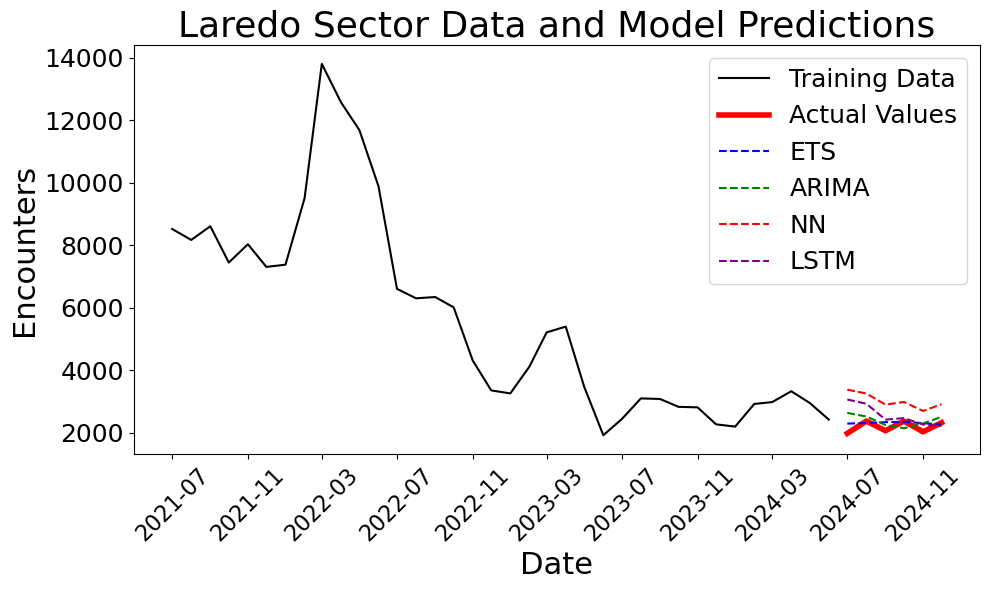

In [11]:
sector = 'Laredo Sector'
plot_data(sector)

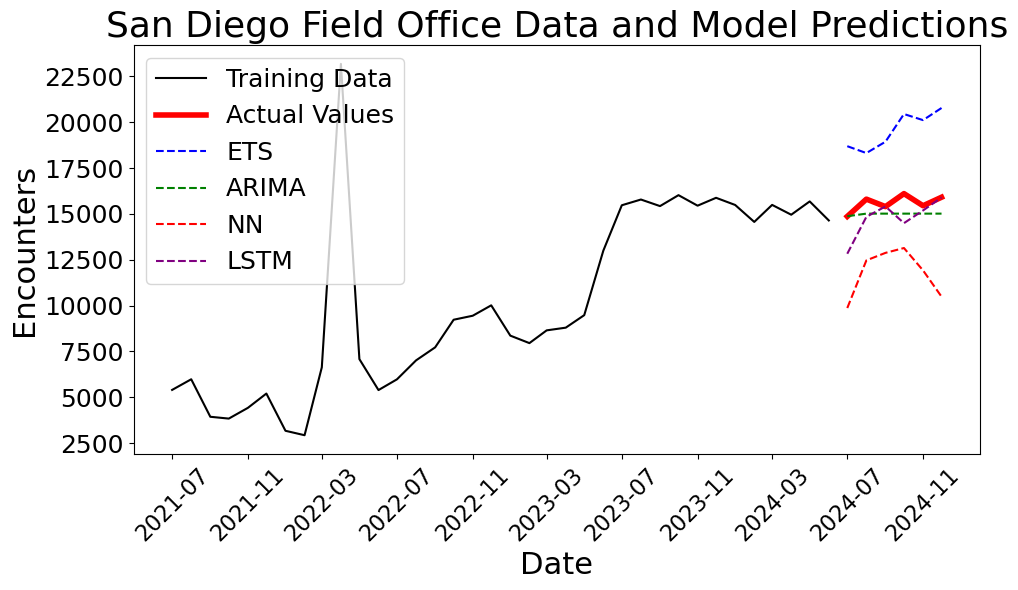

In [12]:
sector = "San Diego Field Office"
plot_data(sector)

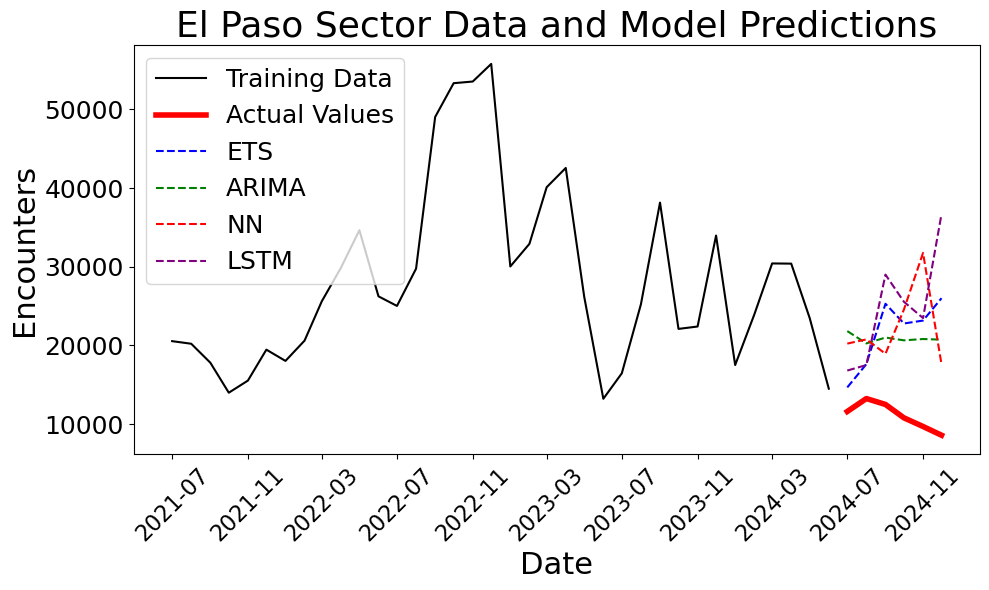

In [13]:
sector = "El Paso Sector"
plot_data(sector)

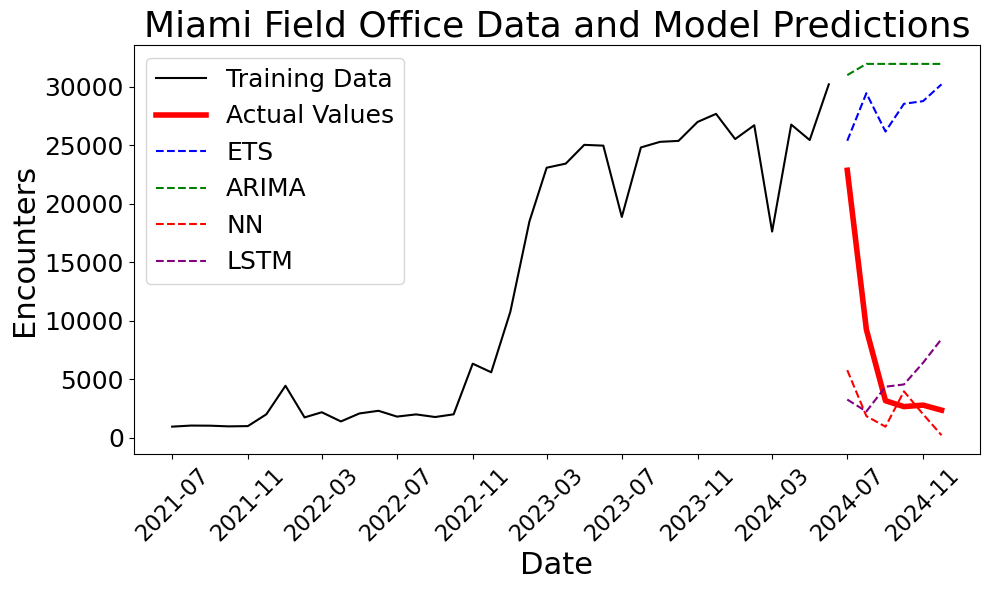

In [15]:
sector = "Miami Field Office"
plot_data(sector)

In [16]:
# Initialize a DataFrame to store the average MAPE for each config_id
lstm_average_mape_results = pd.DataFrame()

# Get the unique config_ids
config_ids = lstm_model_results['config_id'].unique()

# Iterate through each config_id
for config_id in config_ids:
    # Filter the model_results DataFrame to only include rows for the current config_id
    filtered_results = lstm_model_results[lstm_model_results['config_id'] == config_id]

    # Create a DataFrame to store MAPE values for each sector
    mape_df = pd.DataFrame(columns=range(6))

    # Iterate through the filtered results and extract MAPE values
    for index, row in filtered_results.iterrows():
        mape_df.loc[row['sector']] = row['MAPE']

    # Calculate the mean MAPE for each time step
    average_mape = mape_df.mean()

    # Create a DataFrame to store the average MAPE for each time step
    average_mape_df = pd.DataFrame(average_mape, columns=[f'config_id_{config_id}'])

    # Append the average MAPE for the current config_id to the results DataFrame
    lstm_average_mape_results = pd.concat([lstm_average_mape_results, average_mape_df], axis=1)

In [17]:
# Initialize a DataFrame to store the average MAPE for each config_id
nn_average_mape_results = pd.DataFrame()

# Get the unique config_ids
config_ids = nn_model_results['config_id'].unique()

# Iterate through each config_id
for config_id in config_ids:
    # Filter the model_results DataFrame to only include rows for the current config_id
    filtered_results = nn_model_results[nn_model_results['config_id'] == config_id]

    # Create a DataFrame to store MAPE values for each sector
    mape_df = pd.DataFrame(columns=range(6))

    # Iterate through the filtered results and extract MAPE values
    for index, row in filtered_results.iterrows():
        mape_df.loc[row['sector']] = row['MAPE']

    # Calculate the mean MAPE for each time step
    average_mape = mape_df.mean()

    # Create a DataFrame to store the average MAPE for each time step
    average_mape_df = pd.DataFrame(average_mape, columns=[f'config_id_{config_id}'])

    # Append the average MAPE for the current config_id to the results DataFrame
    nn_average_mape_results = pd.concat([nn_average_mape_results, average_mape_df], axis=1)

In [18]:
time_steps = np.arange(1, 7)

In [19]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE for ETS model
ets_mape = []
for col in ets_model_results.columns[1:]:  # Exclude the first column (sector) and the last column (Model)
    ets_mape.append(mean_absolute_percentage_error(test_data[col].values, ets_model_results[col].values))



# Calculate MAPE for ARIMA model
arima_mape = []
for col in arima_model_results.columns[1:]:  # Exclude the first column (sector) and the last column (Model)
    arima_mape.append(mean_absolute_percentage_error(test_data[col].values, arima_model_results[col].values))


In [20]:
ets_mape

[46.74528102142927,
 63.77329329130197,
 79.5089322225622,
 107.60734358157595,
 178.03845860470915,
 192.41807344291553]

In [21]:
arima_mape

[46.90485508578593,
 52.23233742983653,
 68.48046246747056,
 81.31922794413072,
 169.180484255304,
 139.11198736808038]

In [22]:
lstm_mape = lstm_average_mape_results['config_id_1'].values
lstm_mape

array([ 66.18443066,  65.87944369,  67.67529775,  77.67881102,
       161.86678092, 114.59709263])

In [23]:
nn_mape = nn_average_mape_results['config_id_1'].values
nn_mape

array([ 79.41023649,  73.7823541 ,  72.21741402,  68.98993304,
       130.13383021,  90.62296786])

In [24]:
lstm_average_mape_results

,config_id_1
0,66.184431
1,65.879444
2,67.675298
3,77.678811
4,161.866781
5,114.597093


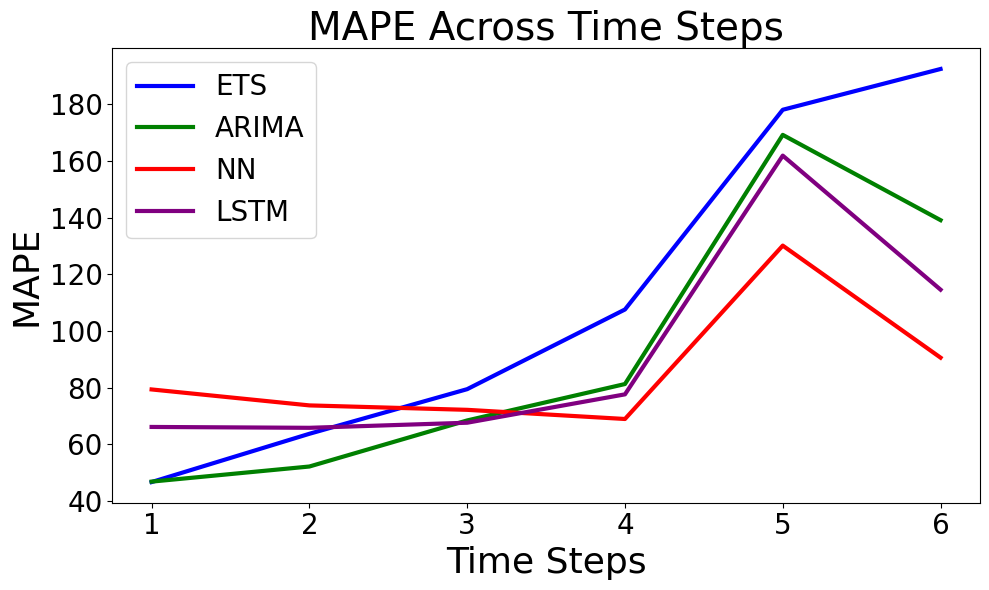

In [25]:
# Plot the data
plt.figure(figsize=(10, 6))

# Plot predictions from different models
plt.plot(time_steps, ets_mape, label='ETS', color='blue', linewidth = 3)
plt.plot(time_steps, arima_mape, label='ARIMA', color='green', linewidth = 3)
plt.plot(time_steps, nn_mape, label='NN', color='red', linewidth = 3)
plt.plot(time_steps, lstm_mape, label='LSTM', color='purple', linewidth = 3)

# Add labels and legend
plt.xlabel('Time Steps', fontsize=26)
plt.ylabel('MAPE', fontsize=26)
plt.title('MAPE Across Time Steps',fontsize=28)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()

In [26]:
# TODO : Separate MAPE out by sector:

southern_sectors = ["San Diego Sector", "El Centro Sector", "Yuma Sector", 
                    "Tucson Sector", "El Paso Sector", 
                    "Del Rio Sector", "Rio Grande Valley Sector"]


In [27]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Filter test_data to only include rows in southern_sectors
test_data_southern = test_data.loc[southern_sectors]
ets_southern = ets_model_results.set_index('Area of Responsibility').loc[southern_sectors]

# Calculate MAPE for ETS model
ets_mape = []
for col in ets_model_results.columns[1:]:  # Exclude the first column (sector) and the last column (Model)
    ets_mape.append(mean_absolute_percentage_error(test_data_southern[col].values, ets_southern[col].values))

arima_southern = arima_model_results.set_index('Area of Responsibility').loc[southern_sectors]

# Calculate MAPE for ARIMA model
arima_mape = []
for col in arima_model_results.columns[1:]:  # Exclude the first column (sector) and the last column (Model)
    arima_mape.append(mean_absolute_percentage_error(test_data_southern[col].values, arima_southern[col].values))


In [28]:
ets_mape

[55.14621221885477,
 66.34871323163063,
 94.81453273712364,
 84.24314781270053,
 142.46281994000748,
 213.67902432211525]

In [29]:
southern_nn_mape = nn_model_results[nn_model_results['sector'].isin(southern_sectors)]['MAPE']
southern_lstm_mape = lstm_model_results[lstm_model_results['sector'].isin(southern_sectors)]['MAPE']
southern_nn_mape.mean()

array([144.8680247 , 157.32576223, 168.1977469 , 149.53011449,
       212.33449242, 255.14270657])

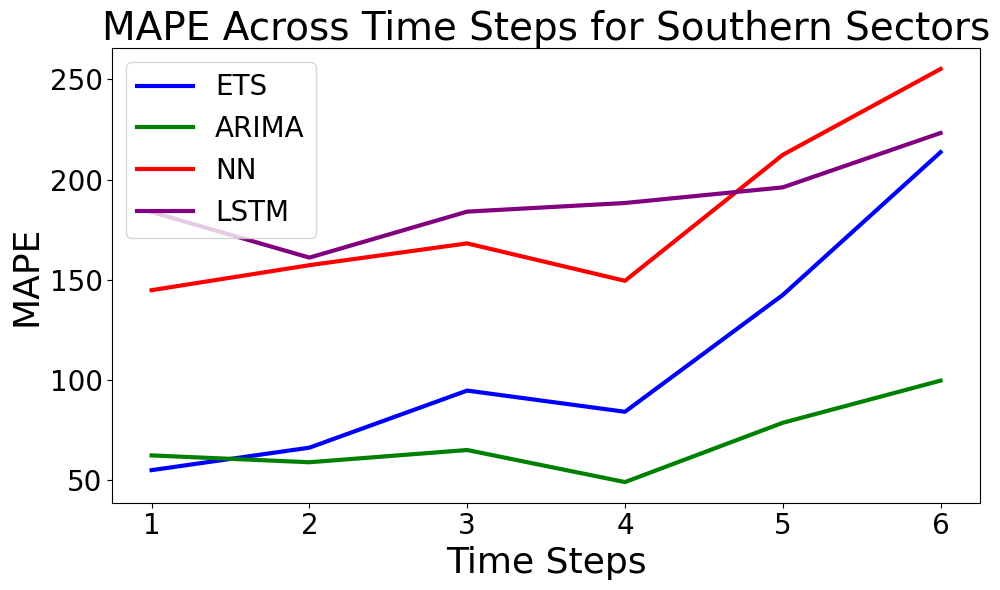

In [30]:
# Plot the data
plt.figure(figsize=(10, 6))

# Plot MAPE from different models
plt.plot(time_steps, ets_mape, label='ETS', color='blue', linewidth=3)
plt.plot(time_steps, arima_mape, label='ARIMA', color='green', linewidth=3)
plt.plot(time_steps, southern_nn_mape.mean(), label='NN', color='red', linewidth=3)
plt.plot(time_steps, southern_lstm_mape.mean(), label='LSTM', color='purple', linewidth=3)


# Add labels and legend
plt.xlabel('Time Steps', fontsize=26)
plt.ylabel('MAPE', fontsize=26)
plt.title('MAPE Across Time Steps for Southern Sectors', fontsize=28)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()